In [1]:
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [2]:
url = "https://raw.githubusercontent.com/LunaHub/Friends_social_data_analysis_2019/master/data/Dataset_with_all_scene_characters.csv"
df = pd.read_csv(url, error_bad_lines=False)

In [3]:
df = df.drop("Unnamed: 0",axis=1)

In [4]:
df.head()

,Speaker,Text,Episode,Scene,Scene_characters
0,monica,"oh, the way you crushed mike at ping pong was...",1001,"[scene barbados, monica and chandler's room. t...",['chandler' 'charlie' 'joey' 'mike' 'monica' '...
1,chandler,"you know, i'd love to, but i'm a little tired.",1001,"[scene barbados, monica and chandler's room. t...",['chandler' 'charlie' 'joey' 'mike' 'monica' '...
2,monica,i'll put a pillowcase over my head.,1001,"[scene barbados, monica and chandler's room. t...",['chandler' 'charlie' 'joey' 'mike' 'monica' '...
3,chandler,you're on!,1001,"[scene barbados, monica and chandler's room. t...",['chandler' 'charlie' 'joey' 'mike' 'monica' '...
4,phoebe,hey!,1001,"[scene barbados, monica and chandler's room. t...",['chandler' 'charlie' 'joey' 'mike' 'monica' '...


In [5]:
#joey = joe, rachel = rach, monica = mon, phoebe = phoebs = phoeb
boys = ["joey","ross","chandler",]
girls = ["rachel","monica","phoebe"]

In [6]:
# function for clearing lines
def cleanLines(line):
    #Exclude links
    line = re.sub(r'\([^)]*\)','',line)
    #Remove everything besides letters
    line = re.sub("([^a-z \t])|(\w+:\/\/\S+)", "", line)
    #Create a string for tweet
    line = [''.join(s for s in line)]
    return(line) 

In [7]:
#Add words to stopwords
stopWords = nltk.corpus.stopwords.words('english')
newStopWords = ["like","get","yeah","know","gonna","hey","uh","oh","well","okay","im","dont","youre","thats","got"]
stopWords.extend(newStopWords)

#create list of real words
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

In [8]:
#Create list for what the boys and girls talk about when they are without the others
allwords = list()
girlssays = list()
girlwords = list()
boyssays = list()
boywords = list()
index = []
for n in range(len(df.Scene_characters)):
    index.append(sum(girl in df.Scene_characters[n] for girl in girls) == 3 and sum(boy in df.Scene_characters[n] for boy in boys) == 0)
says = df.Text[index].reset_index(drop=True)
for i in range(len(says)):
    girlssays.extend(cleanLines(says[i]))
for lines in girlssays:
    words = [w for w in lines.split() if w in english_vocab and w not in stopWords]
    girlwords.extend(words)
allwords.extend(girlwords)




index = []
for n in range(len(df.Scene_characters)):
    index.append(sum(girl in df.Scene_characters[n] for girl in girls) == 0 and sum(boy in df.Scene_characters[n] for boy in boys) == 3)
says = df.Text[index].reset_index(drop=True)

for i in range(len(says)):
    boyssays.extend(cleanLines(says[i]))
for lines in boyssays:
    words = [w for w in lines.split() if w in english_vocab and w not in stopWords]
    boywords.extend(words)
allwords.extend(boywords)

In [9]:
# Calculate the TF of the boys and girls:
theysay = girlwords
TF_girl_words = FreqDist(theysay)
TF_girl = {a:(b/len(theysay)) for (a,b) in TF_girl_words.most_common()}
# Calculate the TF
TF_girl_words = FreqDist(theysay)
TF_girl = {a:(b/len(theysay)) for (a,b) in TF_girl_words.most_common()}

theysay = boywords
TF_boy_words = FreqDist(theysay)
TF_boy = {a:(b/len(theysay)) for (a,b) in TF_boy_words.most_common()}
# Calculate the TF
TF_boy_words = FreqDist(theysay)
TF_boy = {a:(b/len(theysay)) for (a,b) in TF_boy_words.most_common()}


In [10]:
# Calculate the IDF for each word:
IDF = {}
for word in np.unique(allwords):
    denomi = 0
    if word in girlwords: 
        denomi+=1
    if word in boywords: 
        denomi+=1

    IDF[word] = np.log( 2 / (denomi))

In [11]:
# Calcualte the TF-IDF of the boys and girls:
#Girls
TF_IDF_girl = {}
for word in TF_girl.items():
    TF_IDF_girl[word[0]] = word[1] * IDF[word[0]]
TF_IDF_girl = sorted(TF_IDF_girl.items(), key=lambda kv: kv[1],reverse = True)

#Boys
TF_IDF_boy = {}
for word in TF_boy.items():
    TF_IDF_boy[word[0]] = word[1] * IDF[word[0]]
TF_IDF_boy = sorted(TF_IDF_boy.items(), key=lambda kv: kv[1],reverse = True)



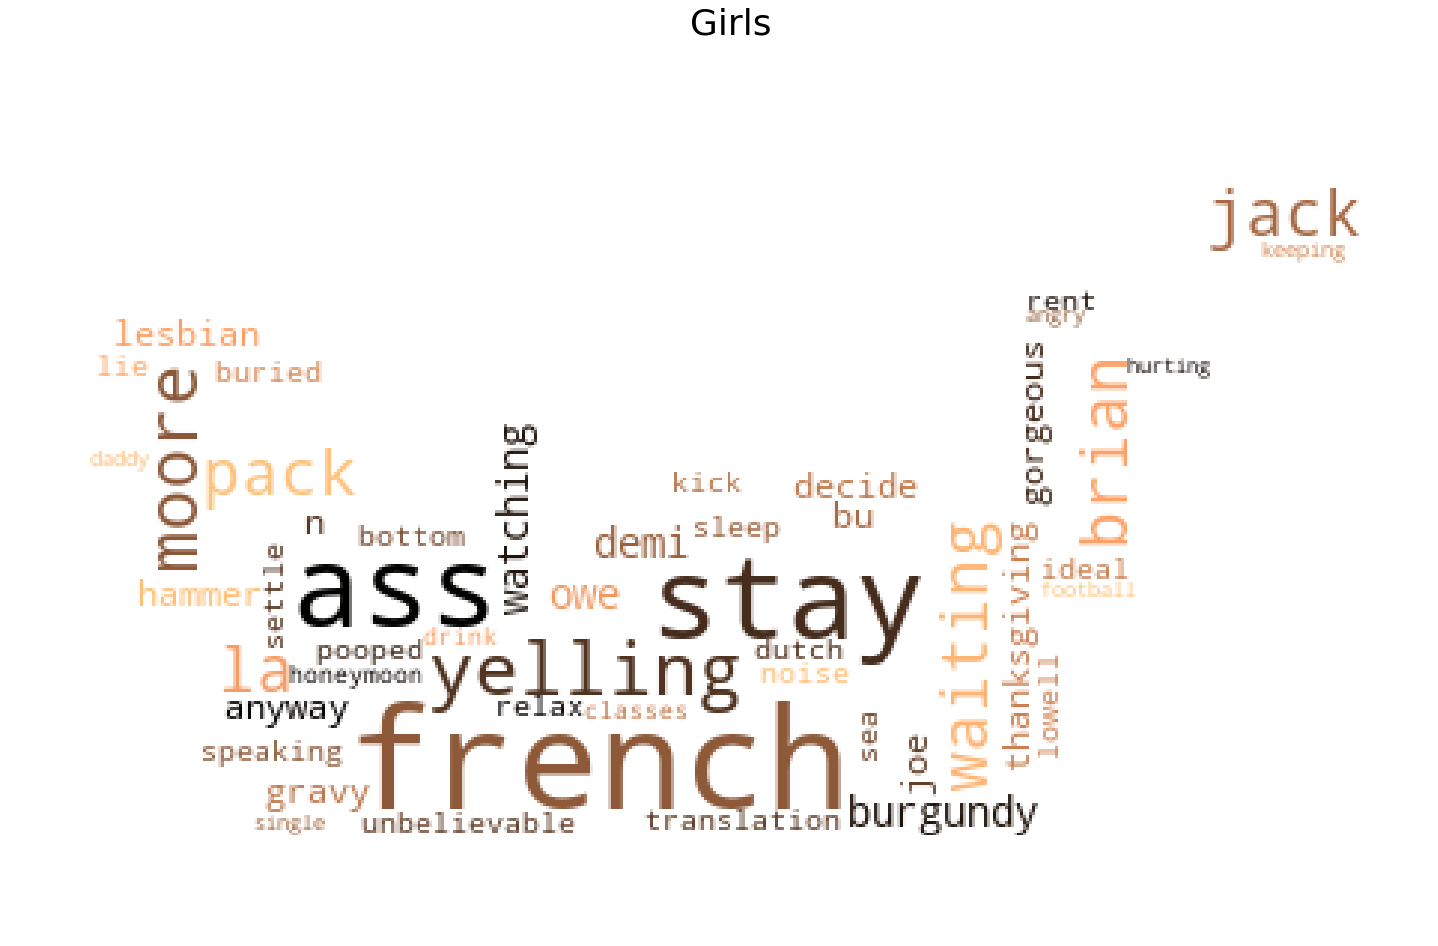

In [12]:
url = "https://raw.githubusercontent.com/LunaHub/Friends_social_data_analysis_2019/master/figures/Friends_siluet.PNG"
response = requests.get(url)
img = np.array(Image.open(BytesIO(response.content)))
plt.figure(figsize = [25,25])
plt.imshow(WordCloud(stopwords=set(list(STOPWORDS) + stopWords),
                     background_color='white',
                     max_words = 50, colormap = 'copper',
                    mask = img)
           .generate_from_frequencies(dict(TF_IDF_girl)));
plt.axis('off');
plt.title('Girls',fontsize = 36);
#plt.savefig("wordcloud_girls",transparent = True, DPI = 200)
plt.show()

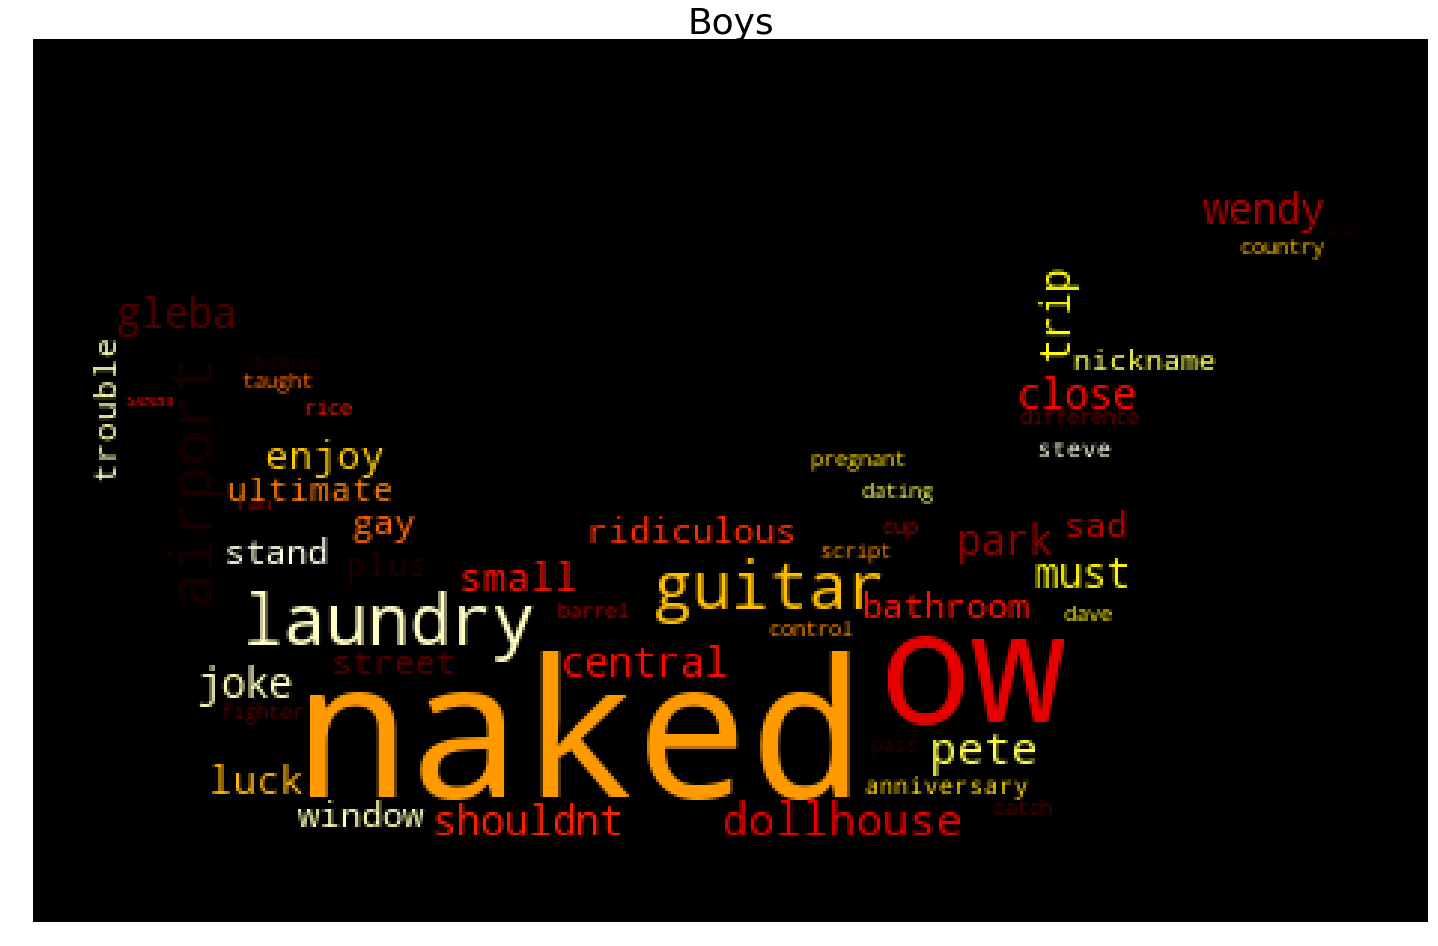

In [13]:
plt.figure(figsize = [25,25])
plt.imshow(WordCloud(stopwords=set(list(STOPWORDS) + stopWords),
                     background_color='black',
                     max_words = 50, colormap = 'hot',
                    mask = img)
           .generate_from_frequencies(dict(TF_IDF_boy)));
plt.axis('off');
plt.title('Boys',fontsize = 36);
#plt.savefig("wordcloud_boys",transparent = True, DPI = 200)
plt.show()